### Q.3. Implement FCN8 model using Keras/Tensorflow library for Building footprint segmentation from aerial remote sensing images 

#### <a>https://github.com/menvuthy/building-footprint-dataset</a> 
#### For implementation, split dataset into training dataset (80%) and testing dataset (20%) ). Use a Adam gradient descent algorithm to learn model with parameters for α = 0.01 and random parameters of the CNN model for Dice Loss function. For better training performance, you can use batch-normalization and dropout if necessary.

#### (i)Plot a comparative loss curve for at least 50 epochs. 
#### (ii) Print confusion matrix, calculate overall as well as classwise classification metrics such as bulding and Background accuracy, Segmentation Accuracy, Dice Coefficient, IoU) on test dataset.

In [1]:
import numpy as np 
import cv2 
from PIL import Image 

import seaborn as sns 
from matplotlib import pyplot as plt 

import tensorflow as tf 
from tensorflow.keras import models, layers 

import os 
from tqdm import *
import pandas as pd 

imgPaths = "../../NNDL_Datasets/Assignment6/Q3_dataset/Data/image"
maskPaths = "../../NNDL_Datasets/Assignment6/Q3_dataset/Data/mask"

In [2]:
tf.config.list_physical_devices("GPU")

2021-11-11 15:32:09.292094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:09.297707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:09.297949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
ip = os.listdir(imgPaths)
imagePaths_ = [os.path.join(imgPaths, i) for i in ip]

mp = os.listdir(maskPaths)
maskPaths_ = [os.path.join(maskPaths, i) for i in mp]

df = pd.DataFrame({
    "Image" : imagePaths_, 
    "Mask": maskPaths_
})

In [4]:
EPOCHS = 50
BATCH_SIZE = 32 
LR = 0.01 

WIDTH = HEIGHT = 512
CHANNELS=3

In [5]:
class AerialDataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, dim = (HEIGHT, WIDTH), n_channels=CHANNELS, shuffle=True):

        self.data = df 
        self.batch_size = batch_size 
        self.idx = self.data.index.tolist()
        self.dim = dim 

        self.channels = n_channels
        self.shuffle = shuffle 
        self.min_depth = 0.1 

        self.on_epoch_end() 

    def __len__(self):
        return int(np.ceil(len(self.data)/self.batch_size)) 

    def __getitem__(self, idx):
        if (idx+1)*self.batch_size > len(self.idx):
            self.batch_size = len(self.idx) - idx*self.batch_size 

        idx = self.idx[idx*self.batch_size : (idx+1)*self.batch_size] 
        batch = [self.idx[k] for k in idx]
        x, y = self.__data_generation(batch)
        return x, y 

    def on_epoch_end(self):
        self.idx = np.arange(len(self.idx)) 
        if self.shuffle:
            np.random.shuffle(self.idx) 


    def load(self, img_path, mask_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)/255.0
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
        mask = mask > 0.5 
        mask = mask.astype(np.float32)
        mask = np.expand_dims(mask, -1) 
        img = tf.image.convert_image_dtype(img, tf.float32)
        mask = tf.image.convert_image_dtype(mask, tf.float32)
        return img, mask


    def __data_generation(self, batch):
        x = np.empty((self.batch_size, *self.dim, self.channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for idx, batch_idx in enumerate(batch):
            x[idx, :], y[idx, :] = self.load(self.data["Image"][batch_idx], self.data["Mask"][batch_idx])

        return x, y 

In [6]:
def visualize(samples, n_samples, model=None):
    x, y = samples 

    if model is not None:
        fig, ax = plt.subplots(n_samples, 3, figsize = (15, 10), constrained_layout=True)
        pred = model.predict(x) 
        for i in range(n_samples):
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i, 1].imshow(y[i])
            ax[i, 1].set_xticks([])
            ax[i, 1].set_yticks([])
            ax[i, 1].set_title("Ground Truth", color="white")

            ax[i, 2].imshow(pred[i])
            ax[i, 2].set_xticks([])
            ax[i, 2].set_yticks([])
            ax[i, 2].set_title("Predicted", color="white")
         

    else :
        fig, ax = plt.subplots(n_samples, 2, figsize = (20, 20), constrained_layout=True)
        for i in range(n_samples): 
            ax[i][0].imshow(x[i], cmap="gray")
            ax[i][0].set_xticks([])
            ax[i][0].set_yticks([])
            ax[i][0].set_title("Input", color="white")

            ax[i][1].imshow(y[i])
            ax[i][1].set_xticks([])
            ax[i][1].set_yticks([])
            ax[i][1].set_title("Output", color="white")


2021-11-11 15:32:13.252314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 15:32:13.253381: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:13.254232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 15:32:13.254542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

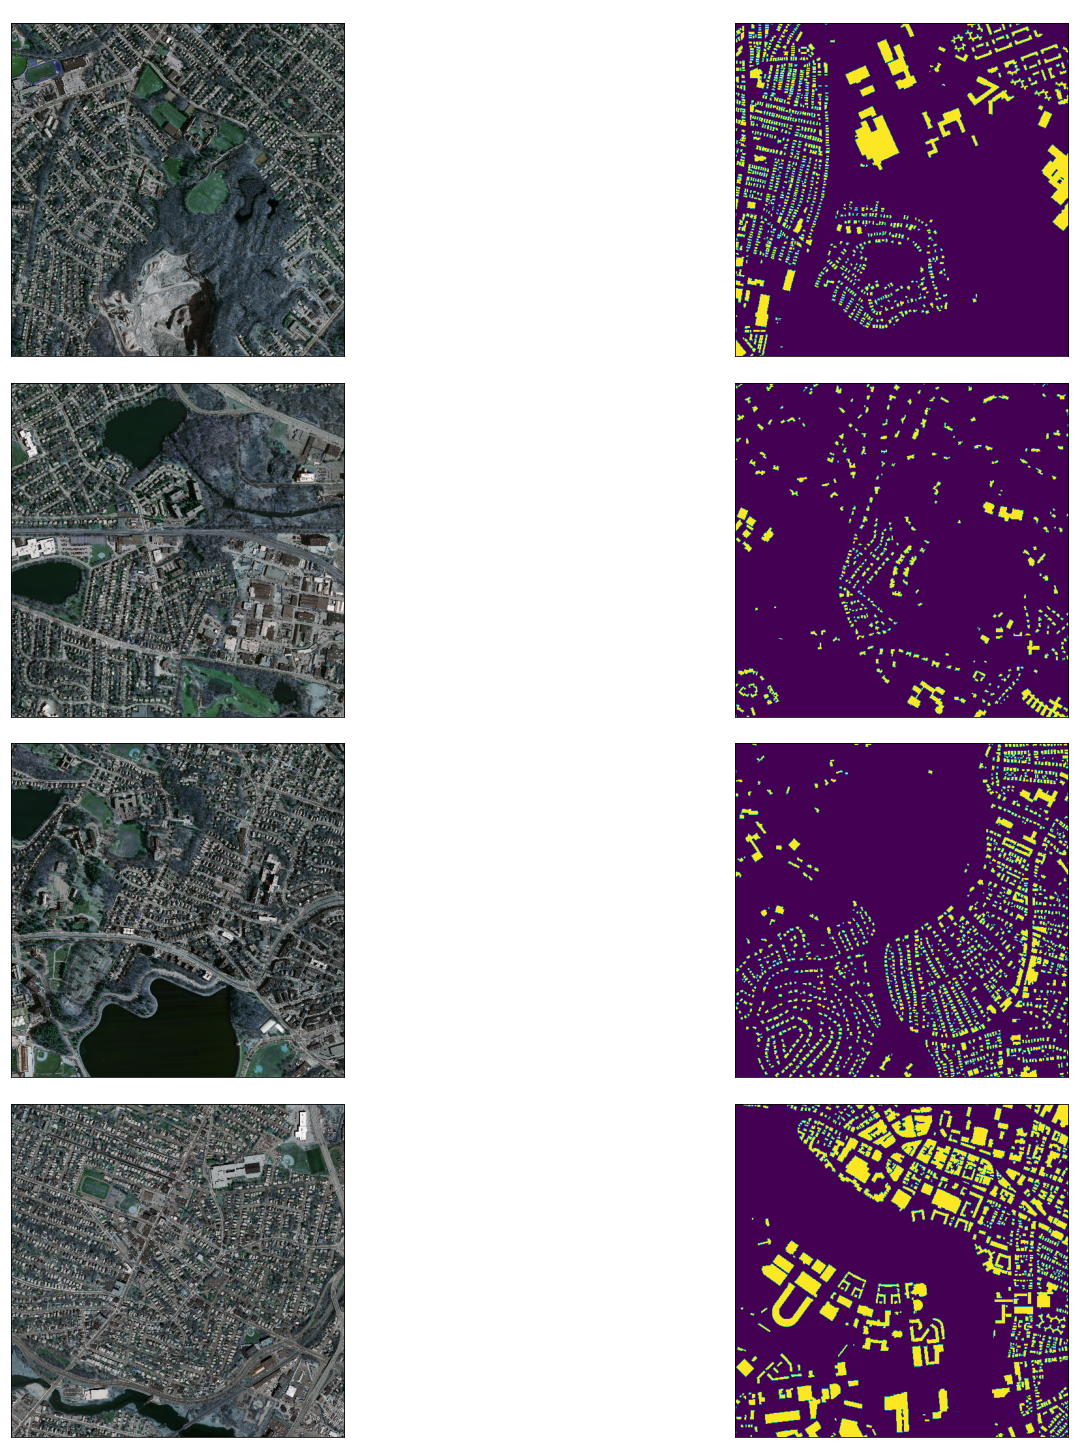

In [7]:
trialGen = AerialDataGenerator(df = df)
v_samples = next(iter(trialGen))
visualize(v_samples, n_samples=4)

In [8]:
from fcn_utils import FCN8 

FCNModel = FCN8(n_classes=2)

TypeError: 'module' object is not callable